# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7fb87a23e3b0>], client=<botocore.client.BedrockRuntime object at 0x7fb86b37c370>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True)

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [9]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [10]:
depoly = False

In [11]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [12]:
if depoly:

    import boto3
    from utils.ssm import parameter_store

    region=boto3.Session().region_name
    pm = parameter_store(region)

    pm.put_params(
        key="reranker_endpoint",
        value=f'{predictor.endpoint}',
        overwrite=True,
        enc=False
    )

## 4. Invocation (prediction)

In [13]:
from utils.ssm import parameter_store

In [14]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [15]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7fb84f3253f0>


In [16]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [17]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [18]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "나는 너를 사랑하지 않아", "text_pair": "나는 너를 좋아하지 않아"},
            {"text": "그는 너를 싫어해", "text_pair": "그는 너를 좋아해"}
        ]
    }
)

In [19]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9984032511711121}, {'label': 'LABEL_0', 'score': 0.004707992542535067}]
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 89.2 ms


## 5. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [20]:
import boto3
from utils.ssm import parameter_store

In [21]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [22]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [23]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [24]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: summit-workshop-index


In [25]:
index_name = "summit-workshop-index"

### OpenSearch Client 생성

In [26]:
from utils.opensearch import opensearch_utils

In [27]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [28]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [34]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    hybrid_search_debugger="None", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=False, # enable parent document
    
    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]

    #rag_fusion=True, # enable rag_fusion
    #query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=False, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [35]:
system_prompt = prompt_repo.get_system_prompt()

In [36]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

아동의 4가지 권리는 생존권, 발달권, 보호권, 참여권입니다.

생존권은 아동이 생명을 유지하고 건강하게 자랄 수 있도록 하는 권리로, 영양가 있는 음식을 먹고 깨끗하고 안전한 환경에서 보호받으며 아플 때 치료받을 수 있는 권리입니다. 

발달권은 아동의 재능과 능력을 펼칠 수 있도록 하는 권리로, 놀이와 여가를 즐길 수 있는 권리입니다.

보호권은 아동의 몸과 마음을 아프게 하는 모든 해로운 것으로부터 보호받을 권리입니다.  

참여권은 아동이 자신과 관련된 문제에 관하여 의견을 말하고 참여할 권리입니다.
-----------------------------------------------
1. Category: CompositeElement, Chunk: 883 Characters
-----------------------------------------------
.goe.go.kr → 전자민원 → 신고 센터 → 공익제보센터→불법찬조금 신고 - 전 화 : 경기도교육청 감사관 031) 820-0852 ○ 안산교육지원청 :
www.goeas.kr→ 열린공간 → 사이버신고센터 - 전 화 : 031) 412-4620 ○ 참교육을 위한 전국학부모회 : www.hakbumo.or.kr →학교길라잡이→
불법찬조금 ○ 국민신문고 :www.epeople.gr.kr → 민원 16 아동학대 예방 교육 11 “아동은 한 인간으로서 고유한 존재이며, 스스로가 권리의 주체자임을 인식하고 적극
적인 참여를 통해 자신의 권리를 온전하게 보장받을 수 있어야 함” (UN아동권리협약) 아동 인권의 보장 22 22 아동의 4가지 권리 생 촌 권 아 동 이 생 명 을 유 지 하 고
건 강 하 게 자 랄 수 있 도록 + 동 미 재 능 과 능 력 을 펼 칠 수 있 도록 고 늘 이 와 여 가 를 즐 길 권 리 명 양 가 있 는 음 식 을 먹 고 깨 끗 하 고 안
전 한 환 경 메 서 = 보 호 받 으 며 아 플 때 치 료 받 을 수 있 는 권 리 = 보 호 권 마 동 의 몽 과 마 음 을 아 프 

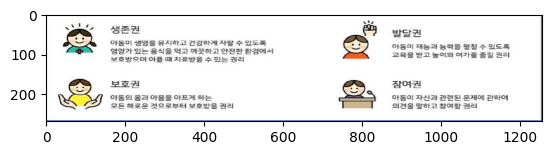

이미지는 생각하는 방식에 대한 4가지 유형을 설명하고 있습니다. 성실형은 아동의 생각을 좋지 않고 건강하게 자를 수 있도록 영향을 주는 습성을 묘사하고, 발달형은 아동이 객관적으로
평가할 수 있도록 돕습니다. 보존형은 아동의 문화 마음을 아프게 하는 모든 해로운 것으로부터 보호할 것을 권리하고, 참여형은 아동이 자신과 관련된 문제에 참여하여 의견을 말하고
참여할 권리가 있음을 설명합니다.
metadata:
 {'img_path': './fig/table-10-resize.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '81499fe5-7dce-488e-bbde-ef701ba1afdf', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
4. Category: Table, Chunk: 191 Characters
-----------------------------------------------


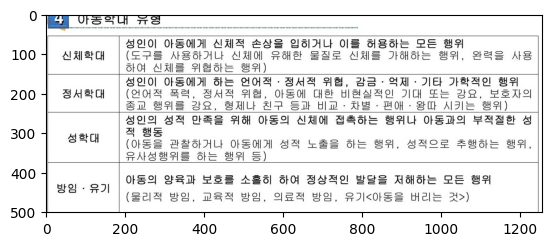

이 표는 아동학대의 유형을 신체학대, 정서학대, 성학대, 방임·유기로 나누어 각각의 정의와 구체적인 행위 예시를 제시하고 있습니다. 신체학대는 신체적 손상을 입히거나 허용하는
행위, 정서학대는 언어적·정서적 위협이나 가혹행위, 성학대는 성인의 성적 만족을 위한 부적절한 행위, 방임·유기는 아동의 양육과 보호를 소홀히 하는 행위를 의미합니다.


정 서 학 대,"성 인이 아 동 에 게 ( 언 어 적 폭 력 , 정 종 교 행 위 를 강 요","하 는 언 어 적 ㆍ 정 서 적 위 협 , 감 금 ㆍ 억 제 ㆍ 기타 가 학 적 인 행 위 서 적 위 협 , 아 동 에 대 한 비 현 실 적 인 기 대 또 는 강 요 , 보 호 자 의 , 형 제 나 친 구 등과 비 교 ㆍ 차 별 ㆍ 편 애 ㆍ 왕 따 시 키 는 행 위 )"
성 학 대,성 인 의 성 적 만 족 정 핸 동 적 행 동 ( 아 동 을 관 찰 하 거 유 사 성 행 위 를,"을 위해 아 동 의 신 체 에 접 촉 하 는 행 위 나 아 동 과 의 부 적 절 한 성 나 아 동 에 게 성 적 노 출 을 하 는 행 위 , 성 적 으 로 추 행 하 는 행 위 , 하 는 행 위 등 )"
방임 ㆍ 유 기,아 동 의 양 육 과 보 ( 물 리 적 방 교,"호 를 소 홀 히 하 여 정 상 적 인 발 달 을 저 해 하 는 모 든 행 위 육 적 방 의 료 적 ¢y, 유 기 < 아 동 을 버 리 는 것 >)"
,"임 ,","임 ,"
,,


metadata:
 {'source': './data/complex_pdf/school_edu_guide.pdf', 'detection_class_prob': 0.37135568261146545,
'coordinates': {'points': [[156.2832794189453, 1585.385009765625], [156.2832794189453,
2086.09521484375], [1413.203369140625, 2086.09521484375], [1413.203369140625, 1585.385009765625]],
'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2337}, 'last_modified':
'2024-04-04T01:39:24', 'text_as_html': '<table><thead><th>신 체 학 대</th><th>성 인이 아 동 에 게 ( 도 구 를 사 용 하
하 여 신 체 를 위 협</th><th>신 체 적 손 상 을 입 히 거 나 이 를 허 용 하 는 모 든 행 위 거 나 신 체 에 유 해 한 물 질 로 신 체 를 가 해 하 는 행
위 , 완 력 을 사 용 하 는 행 위 )</th></thead><tr><td>정 서 학 대</td><td>성 인이 아 동 에 게 ( 언 어 적 폭 력 , 정 종 교 행 위 를 강
요</td><td>하 는 언 어 적 ㆍ 정 서 적 위 협 , 감 금 ㆍ 억 제 ㆍ 기타 가 학 적 인 행 위 서 적 위 협 , 아 동 에 대 한 비 현 실 적 인 기 대 또 는 강
요 , 보 호 자 의 , 형 제 나 친 구 등과 비 교 ㆍ 차 별 ㆍ 편 애 ㆍ 왕 따 시 키 는 행 위 )</td></tr><tr><td>성 학 대</td><td>성 인 의 성
적 만 족 정 핸 동 적 행 동 ( 아 동 을 관 찰 하 거 유 사 성 행 위 를</td><td>을 위해 아 동 의 신 체 에 접 촉 하 는 행 위 나 아 동 과 의 부 적 절 한
성 나 아 동 에 게 성

In [37]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

#query = "수익률 그래프 설명해줘"
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "전년 동기 현금 예치금 구성비 알려줘"
#query = "자산총계 금액 알려줘"
#query = "대출채권 금액은?"

#query = "대출채권의 전년동기에 해당하는 구성비는 얼마입니까?"
#query = "당기손익-공정가치측정유가증권 전년동기의 구성비는?"

query = "재난 발생 시 대처사항은?"
query = "학교폭력 처리 과정은?"
#query = "감염병의 종류와 경로는?"
query = "홍역에 대한 백신 이름은?"

query = "부모가 자녀에게 가르쳐야 할 성지식에는 어떤 것이 있나요?"
#query = "MMR 2차의 예방접종 시기는?"
#query = "교육목표는?"
#query = "만기상환금액 알려줘"
query = "아동의 권리는?"

response, contexts = qa.invoke(
    query=query,
    verbose=False
)

show_context_used(contexts)

### Parameter updates

In [176]:
opensearch_hybrid_retriever.update_search_params(
    k=7,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger="None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    
    rag_fusion=False, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    
    hyde=False, # enable hyde
    hyde_query=["web_search"], # query type in hyde 
    
    parent_document=False, # enable parent document
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다. 단, 
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [177]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

##
#query = "학기 초에 어린이 납치 예방 방법은?" # semantic o, lexical x
#query = "창의적 마인드로 미래를 내다 볼 수 있기 위해 어떤 것들을 길러야 하나요?"# semantic x, lexical o, reranker 7 -> 3 "어린이들의 소질 로 컨택스트 검색"
#query = "학교 오기전에 맞아야 할 예방접종 종류는?" # for table
query = "학교에서 발생할 수 있는 감염병의 종류와 감염경로?" # 테이블 질문
#query = "위반 행위 발견 시 신고 처리 절차는?" # for diagram

query = "음주 및 흡연 예방을 위한 교육을 자세히 최대한 설명해줘"


In [178]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)

1. 학생 흡연의 피해
- 일산화탄소 영향으로 두뇌 활동이 저하되고 학습능력이 떨어집니다.
- 성인에 비해 폐 용적이 작아 담배연기로 인한 피해가 더 크고, 폐 성숙에 장애를 가져옵니다. 
- 성장기에는 세포분열이 왕성하므로 흡연으로 인해 세포의 성장이 방해받을 수 있습니다.
- 어릴 때부터 시작하면 니코틴 중독이 더 심해져 금연이 어려워집니다.
- 15세 이전 흡연자는 25세 이후 흡연자보다 폐암 등의 사망률이 2~3배 더 높습니다.
- 어린 시기 흡연은 유전자 변형을 일으켜 2세에게 나쁜 유전자를 전달합니다.

2. 어린이 간접흡연의 피해
- 성장에 영향을 미쳐 키가 잘 자라지 않습니다.
- 급성 호흡기 질환 감염률이 5.7배 높습니다. 
- 폐암에 걸릴 가능성이 2배 높아집니다.
- 천식, 중이염, 폐렴에 걸릴 확률이 6배 높습니다.
- 뇌세포 파괴로 기억력, 학습능력이 떨어집니다.
- 장기적으로 청력이 떨어집니다.

3. 알코올의 작용
- 뇌기능을 억제시켜 기분을 좋게 합니다.
- 각 장기와 조직에 머물면서 해를 줍니다.
- 우리 몸 세포의 산소 신진대사와 영양물질 흡수를 방해하여 영양장애를 초래합니다.
- 수면장애를 일으킵니다.

In [179]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)

##################################
query:  음주 및 흡연 예방을 위한 교육을 자세히 최대한 설명해줘
##################################


### Answer ###
1. 학생 흡연의 피해
- 일산화탄소 영향으로 두뇌 활동이 저하되고 학습능력이 떨어집니다.
- 성인에 비해 폐 용적이 작아 담배연기로 인한 피해가 더 크고, 폐 성숙에 장애를 가져옵니다.
- 성장기에는 세포분열이 왕성하므로 흡연으로 인해 세포의 성장이 방해받을 수 있습니다.
- 어릴 때부터 시작하면 니코틴 중독이 더 심해져 금연이 어려워집니다.
- 15세 이전 흡연자는 25세 이후 흡연자보다 폐암 등의 사망률이 2~3배 더 높습니다.
- 어린 시기 흡연은 유전자 변형을 일으켜 2세에게 나쁜 유전자를 전달합니다.

2. 어린이 간접흡연의 피해
- 성장에 영향을 미쳐 키가 잘 자라지 않습니다.
- 급성 호흡기 질환 감염률이 5.7배 높습니다.
- 폐암에 걸릴 가능성이 2배 높아집니다.
- 천식, 중이염, 폐렴에 걸릴 확률이 6배 높습니다.
- 뇌세포 파괴로 기억력, 학습능력이 떨어집니다.
- 장기적으로 청력이 떨어집니다.

3. 알코올의 작용
- 뇌기능을 억제시켜 기분을 좋게 합니다.
- 각 장기와 조직에 머물면서 해를 줍니다.
- 우리 몸 세포의 산소 신진대사와 영양물질 흡수를 방해하여 영양장애를 초래합니다.
- 수면장애를 일으킵니다.


### Contexts ###

-----------------------------------------------
1. Category: CompositeElement, Chunk: 979 Characters
-----------------------------------------------
. - 14 - □8 흡연 및 음주 예방 교육 보건교사 김○혜 1. 학생 흡연의 피해 일산화탄소 영향으로 두뇌 활동이 저하되고, 학습능력이 떨어집니다. 성인에 비해 폐 용적이 작아
담배연기로 인한 피해가 더 크

### Multi-turn using chat history

In [42]:
from utils.chat import chat_utils
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

#### Momory setting and Save query and response as chat history

In [ ]:
memory = chat_utils.get_memory(
    memory_type="ConversationBufferMemory",
    memory_key="chat_history"
)

history = memory.load_memory_variables({})["chat_history"]

In [ ]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [ ]:
print('memory: ', history)

#### Rephrase quetions based on chat hostory 

In [ ]:
human_prompt = """
               Here is the question: <question>{question}</question>
               Write in Korean.
               """
               
system_prompt = prompt_repo.get_contextualize_system_prompt()
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [ ]:
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        MessagesPlaceholder("chat_history"),
        human_message_template
    ]
)

In [ ]:
chain = contextualize_q_prompt | llm_text | StrOutputParser()

In [ ]:
#query = "첫 번째 답에서 각 사례, 유형은 뭐가 있어?"
query = "학교에서 발생할 수 있는 감염병의 종류와 감염경로?"

history = memory.load_memory_variables({})["chat_history"]
print('memory: ', history)
revised_question = chain.invoke(
    {
        "chat_history": history,
        "question": query,
    }
)
revised_question = revised_question.replace("<result>", "").replace("</result>", "")
print ("=============")
print (f'revised_question: {revised_question}')

In [ ]:
print (f'revised_question: {revised_question}')

#### Repeat QA and save chat history

In [ ]:
response, contexts = qa.invoke(
    query = revised_question,
    verbose=False
)

In [ ]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [ ]:
print('memory: ', history)